## Introduction
We have a large dataset on the anime watchers on the MyAnimeList website. 
In this notebook, we will explore and discuss the findings of trying to create an Anime recommendation system from the data.

## Data
In order to solve our objective, we are making use of a Kaggle dataset that essentially includes the three following things sourced from the website MyAnimeList (an online website community/database for people who watch anime):
- User List: a snapshot list of all the users in their database and some profile data, including but not limited to their birthdate, gender, location, number of anime watched, etc.
- Anime List: a snapshot list of all anime in their database when this dataset was curated
- Anime-lists List: a snapshot of the lists of anime each User has interacted with in some way (marked as to watch, watched in entirety or partly, etc.), their ratings, how many comments they left on them, etc.

There is a lot of data here to inspect.
We note that the kaggle dataset provides different versions of the CSV files, raw, cleaned, and filtered. Under the project time constraints, we only investigated the cleaned csv files and will only be looking at the data inside those files.

Note for complete transparency, we have made use of AI text generation tools to aid in the completion of work as permitted in the syllabus, such as ChatGPT, to keep up with the quickly moving modern landscape. 

## Data Preparation
There is a lot of data to be parsed through, so let us take a look at a couple of samples from each relevant csv file.
If we take a look at a couple of observations in each CSV file we can see that they contain a lot of useful information.

Loading all of the dataframes at once will take a little while.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# association rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# svd
import surprise
from surprise import SVD, Dataset, Reader

# knns
from sklearn.neighbors import NearestNeighbors
import random

%matplotlib inline
%config InlineBackend.figure_format='retina'

/home/wang/anaconda3/envs/csci349/lib/python3.10/site-packages/surprise/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import get_distribution
/home/wang/anaconda3/envs/csci349/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/wang/anaconda3/envs/csci349/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [2]:
df_users = pd.read_csv("./data/users_cleaned.csv")
df_anime = pd.read_csv("./data/anime_cleaned.csv")
df_anime_lists = pd.read_csv("./data/animelists_cleaned.csv")

In [3]:
df_users.iloc[0]

username                               karthiga
user_id                                 2255153
user_watching                                 3
user_completed                               49
user_onhold                                   1
user_dropped                                  0
user_plantowatch                              0
user_days_spent_watching              55.091667
gender                                   Female
location                        Chennai, India 
birth_date                  1990-04-29 00:00:00
access_rank                                 NaN
join_date                   2013-03-03 00:00:00
last_online                 2014-02-04 01:32:00
stats_mean_score                           7.43
stats_rewatched                             0.0
stats_episodes                             3391
Name: 0, dtype: object

In [4]:
df_anime.iloc[0]

anime_id                                                       11013
title                                                  Inu x Boku SS
title_english                              Inu X Boku Secret Service
title_japanese                                                妖狐×僕SS
title_synonyms                                       Youko x Boku SS
image_url          https://myanimelist.cdn-dena.com/images/anime/...
type                                                              TV
source                                                         Manga
episodes                                                          12
status                                               Finished Airing
airing                                                         False
aired_string                            Jan 13, 2012 to Mar 30, 2012
aired                     {'from': '2012-01-13', 'to': '2012-03-30'}
duration                                             24 min. per ep.
rating                            

In [5]:
df_anime_lists.iloc[0]

username                          karthiga
anime_id                                21
my_watched_episodes                    586
my_start_date                   0000-00-00
my_finish_date                  0000-00-00
my_score                                 9
my_status                                1
my_rewatching                          NaN
my_rewatching_ep                         0
my_last_updated        2013-03-03 10:52:53
my_tags                                NaN
Name: 0, dtype: object

In order to process the data, we need to know which models we will use so that we can process the data FOR the modeling. So let's talk about the models that we will use.

1. Association Rule Mining
   > In the world of association rule mining, we make predictions based off of patterns in a dataset of sets of objects and how frequent some items or sets show up give us information about how likely they are to appear with other items. We will need to construct transactions (sets) of anime that are watched together. To keep things simple, we will consider a transaction to be the set of anime each user has watched. After we have produced our strong association rules, we will then create a powerset of the itemsets (yes that's a lot) of the user input list of anime to predict on, and try to match the greatest itemset in the antecedents of the rules, from most items to least items, from the best rules to the worst rules, and return the consequents. With some parameters, we can control if we just return the top consequent itemset or all of the matched consequents from the rules. Therefore, for Association Rule Mining we will need to use data from `df_anime_list`.
3. SVD
   > To use SVD, we will need to view our data and how we make predictions differently. We use the idea of user-based collaborative filtering, which basically leverages the anime ratings that other users give to their watched anime, and what ratings the current user has given to their watched anime, to predict what the current user would rate anime that they have NOT watched that other users have watched and rated in order to give them recommendations. After training on our dataset, we can use this algorithm to make rating predictions on the entire set of anime that the current user has NOT watched. Then, we simply return the top k anime to recommend k anime to the user. Therefore, for SVD we will need to use data from `df_anime_list` and `df_users`. 
5. kNNs
   > For kNNs, we want to consider the other features that the previous two methods have not touched (Association Rules extract wisdom from the crowds and basically makes an implicit assumption that most people will actually seek out anime that they like to watch and SVD also uses wisdom of the crowds and the ratings that they give to anime to know what anime are good and which ones are bad). We will use the genre information of anime to find "similar" anime based off of how many genres they match to other anime. Therefore, for kNNs we will need to use data from `df_anime`. 

## General Preprocessing

### Utility Mapping Functions

In [6]:
# Map to and from username to id
userName2userIDMap = {}
userID2userNameMap = {}

def foo(row):
    global userName2userIDMap, userID2userNameMap
    k,v = row.username, row.user_id
    if k not in userName2userIDMap:
        userName2userIDMap[k] = v
    if v not in userID2userNameMap:
        userID2userNameMap[v] = k

df_users.apply(foo, axis=1);

In [7]:
# Map to and from anime name to id

animeID2animeNameMap = {}
animeName2animeIDMap = {}

def foo(row):
    global animeID2animeNameMap, animeName2animeIDMap
    id_,title = row.anime_id, row.title
    animeID2animeNameMap[id_] = title
    animeName2animeIDMap[title] = id_

df_anime.apply(foo, axis=1);

### Association Rule Preprocessing

In [8]:
# remove extraneous columns that we are not using for association rule mining.
df_association_rules = df_anime_lists.drop(columns=df_anime_lists.columns[2:])

# let's try to downcast the int data types.
intCols = df_association_rules.select_dtypes('int').columns
df_association_rules[intCols] = df_association_rules[intCols].apply(pd.to_numeric, downcast='integer')

### SVD Preprocessing

In [9]:
# convert the usernames into user_ids
user_ids = []
def foo(row):
    global user_ids
    user_ids.append(userName2userIDMap[row.username])

df_anime_lists.apply(foo, axis=1);

In [10]:
df_svd = pd.DataFrame(data={
    'user_id': user_ids,
    'anime_id': df_anime_lists['anime_id'],
    'score': df_anime_lists['my_score'],
})

### kNN Preprocessing

In [11]:
# remove anime that have no genres, since we are relying solely on the genre features to determine similarity.
df_knn = df_anime[~df_anime['genre'].isna()]

In [12]:
# create a set of the genres
all_genre_set = set()

def foo(row):
    x = row.genre

    if not isinstance(x, str):
        print(f'anomoly genre: {x}')

    if ',' not in x:
        all_genre_set.add(x)
        return
    
    x = x.replace(' ', '').split(',')
    if len(x) > 0:
        for g in x:
            all_genre_set.add(g)
    

df_knn.apply(foo, axis=1);

In [13]:
# Clean and split the genre string into a list for each row
def split_genres(genre):
    if not isinstance(genre, str):
        return []
    return [g.strip() for g in genre.split(',')]

# Apply the function to the genre column to split the genres
df_knn['genre_list'] = df_knn['genre'].apply(split_genres)

/tmp/ipykernel_75130/2620349618.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knn['genre_list'] = df_knn['genre'].apply(split_genres)


In [14]:
# Create the one-hot encoding columns
genre_df = pd.DataFrame(0, index=df_knn.index, columns=list(all_genre_set))

# Populate the DataFrame: for each anime, set 1 for genres it has
for index, row in df_knn.iterrows():
    genres = row['genre_list']
    for genre in genres:
        if genre in all_genre_set:  # This check is technically redundant but safe
            genre_df.at[index, genre] = 1

In [15]:
df_knn = df_knn[['anime_id']].join(genre_df)

## EDA
Let's look at the data that we will use for Modeling.

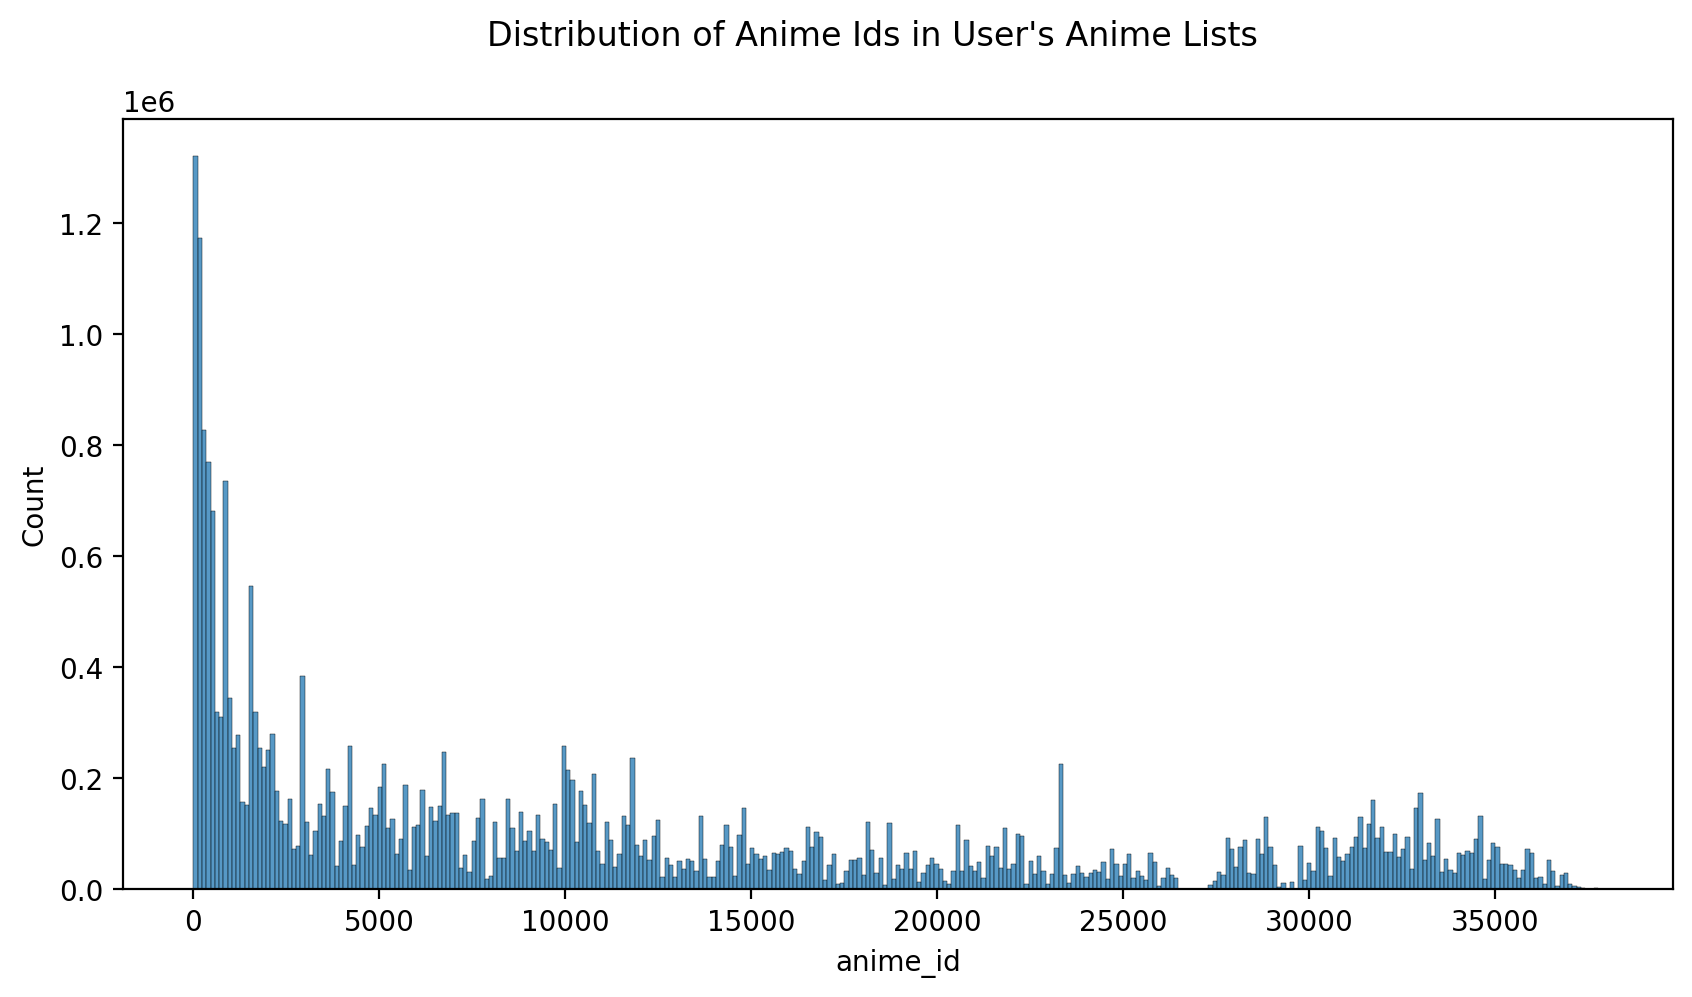

In [17]:
# distribution of anime ids in user's anime lists
# (to see which anime ids occur more often than others)
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.histplot(df_anime_lists, x='anime_id', ax=ax)
fig.suptitle("Distribution of Anime Ids in User's Anime Lists");

Text(0.5, 0.98, 'Distribution of Anime Rating Scores')

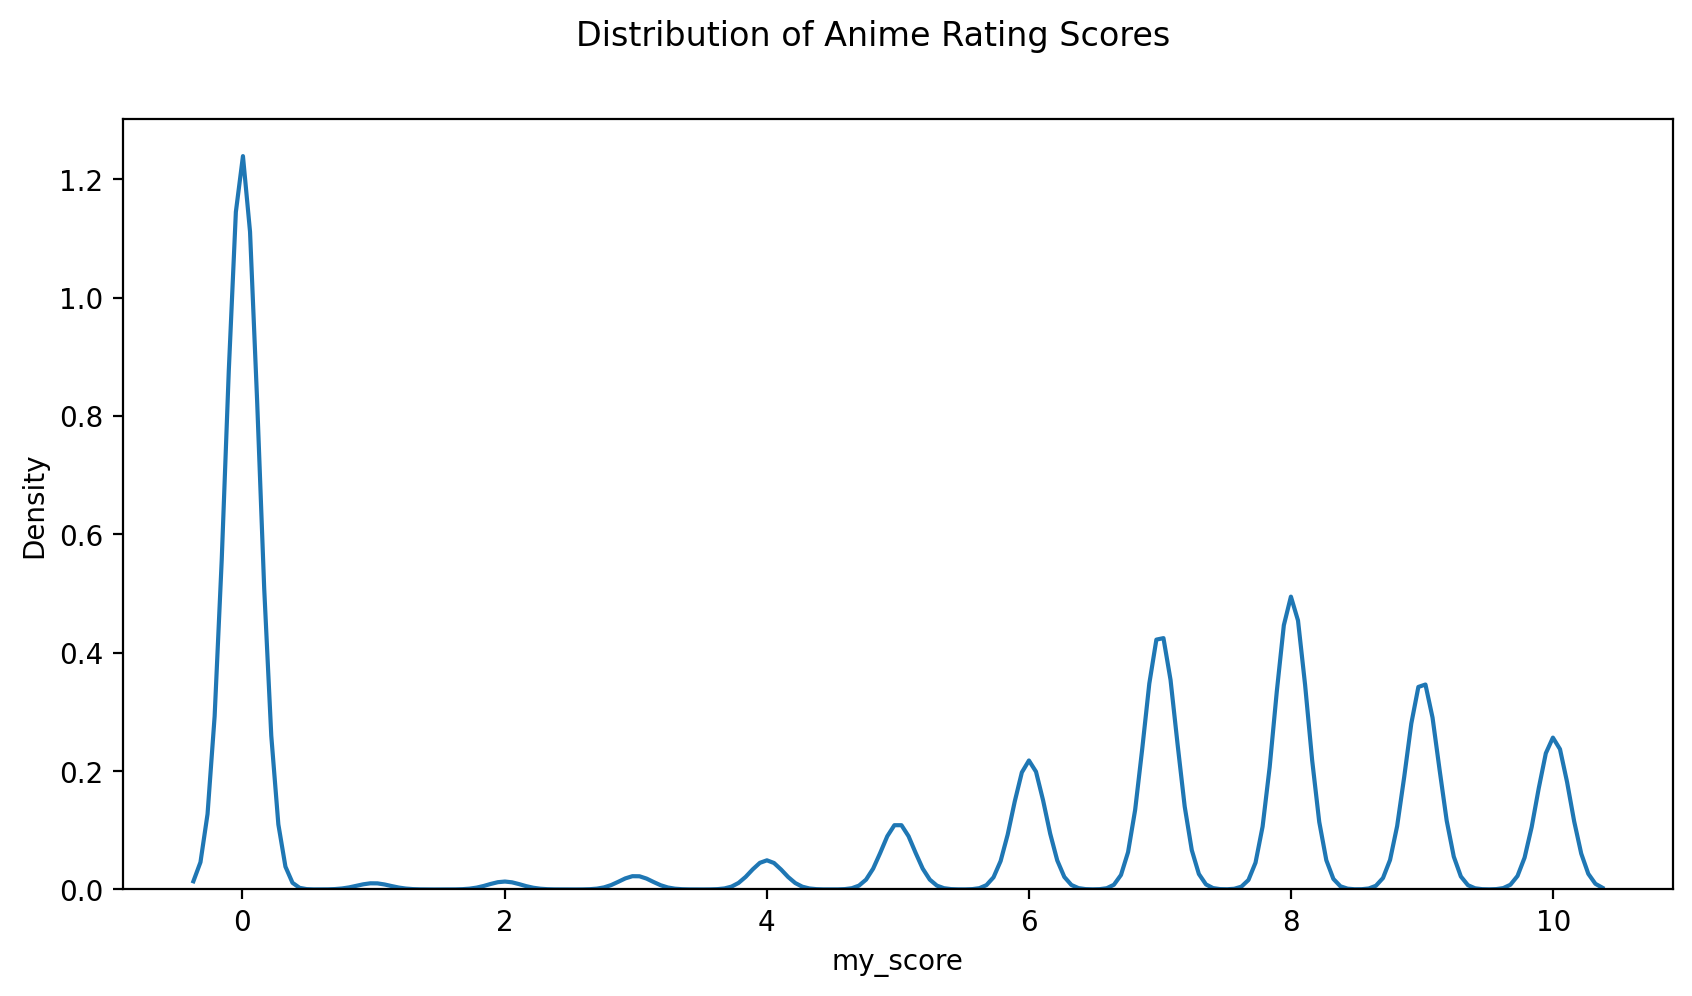

In [18]:
# distribution of scores 
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.kdeplot(df_anime_lists, x='my_score', ax=ax)
fig.suptitle("Distribution of Anime Rating Scores")

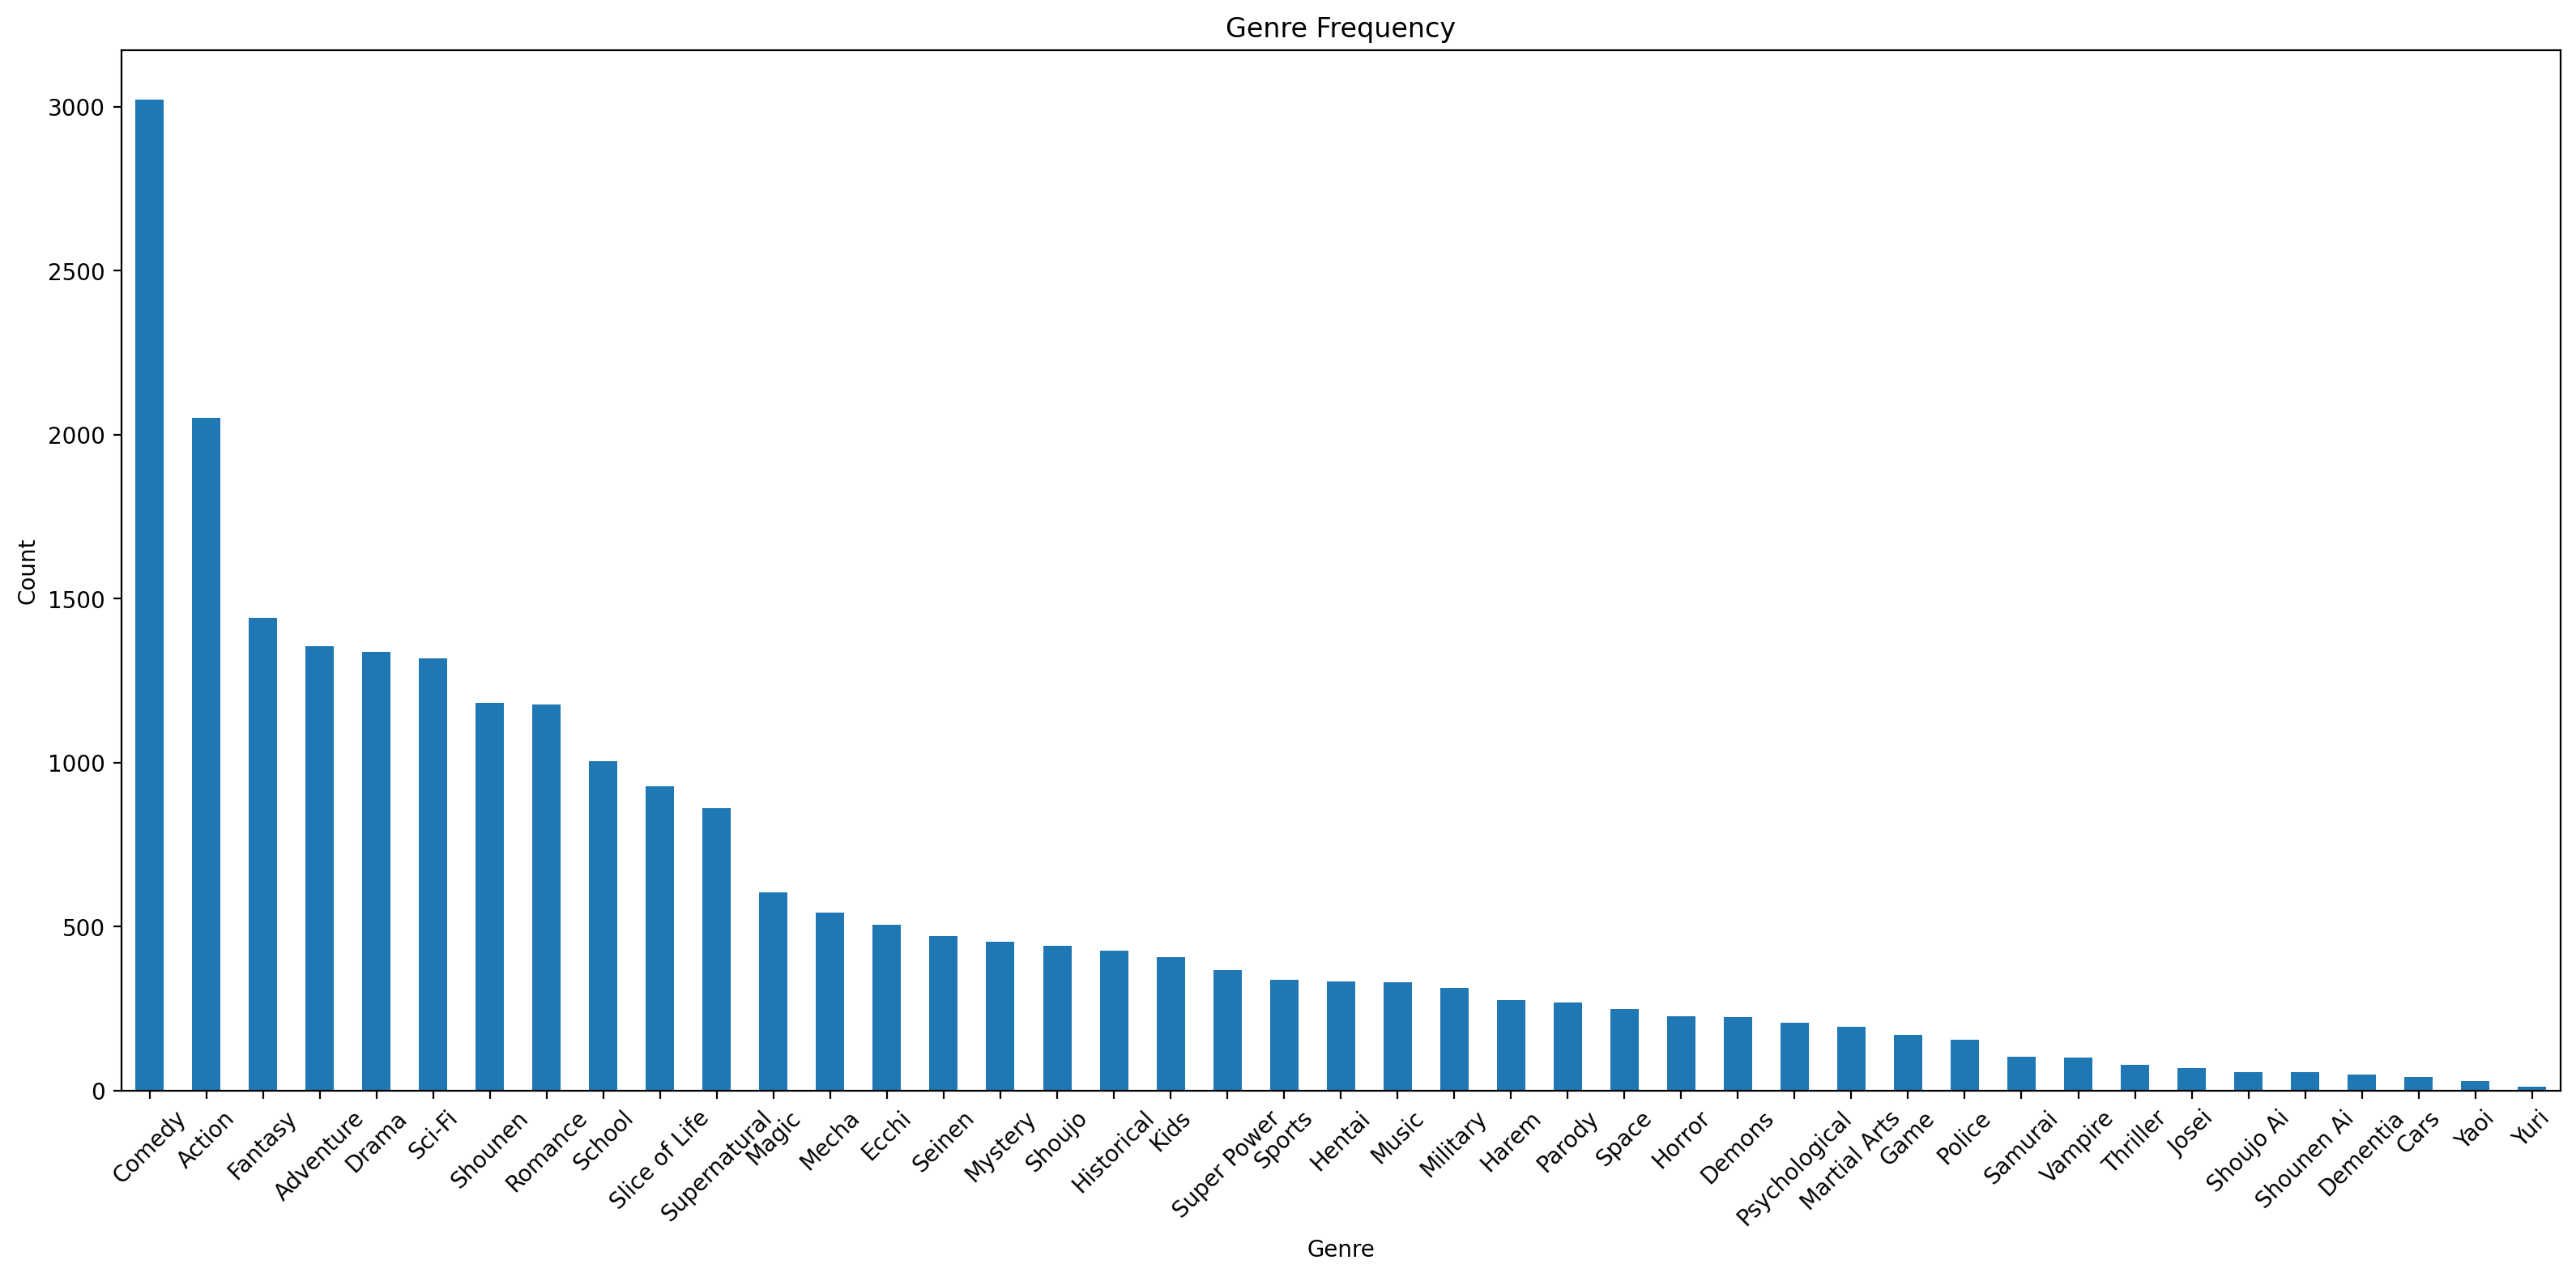

In [36]:
# distribution of genres
tmp = df_anime[~df_anime['genre'].isna()]
tmp = tmp[['genre']]
tmp['genre_list'] = tmp['genre'].apply(split_genres)
tmp = tmp[['genre_list']]

# Flatten the list of genres and count each genre
genre_counts = tmp.explode('genre_list')['genre_list'].value_counts()

plt.figure(figsize=(16, 8)) 
genre_counts.plot(kind='bar')
plt.title('Genre Frequency')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Garbage Collect the Raw DataFrames

In [20]:
del df_anime
del df_users
del df_anime_lists

## Modeling

Since we needed to talk about the models in the previous section to know how to preprocess the data, we will now simply run the models and demonstrate how they work on some sample input.

### Association Rules

In [21]:
def viewTopKRules(rules : pd.DataFrame, metric : str | list[str], k : int, ascending : bool = False) -> pd.DataFrame:
    '''
    return a subset of the rules dataframe 
    given the metric / metrics to sort by
    top k to return
    and whether to be sorted in ascending or descending order
    '''
    return rules.sort_values(by=metric, ascending=ascending).head(k)

In [22]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [23]:
def ar_recommend_anime(rules : pd.DataFrame,  userList : list[str] , short : bool = False) -> list[str]:
    '''
    Given a list of anime the user watches, return a list of anime recommendations.

    This is the better version that tries to match as much of animes in the original list.
    Then we start to add more recommendations by using rules that match fewer and fewer until we are matching rules from singleton animes from userList.

    Input data:
        userList - list of user anime to make predictions off of.
        short - boolean to toggle whether to return a short list of recommended anime or not. the short version 
            is just the consequent anime(s) in the first association rule whose antecedent matches with
            the longest subset in userList.

    Return data format:
        (anime_recommendation, score1, score2)
            score1 - this is the number of animes used to match the rule for this rec (higher is better)
            score2 - this is how far away from the strongest/top rule this rec was found at (lower is better)
    
    '''
    assert isinstance(userList, list), 'input not of type list'
    
    retList = []
    retAnime = set()

    # create all subsets with at least 1 anime
    tmp = [x for x in powerset(userList)]
    tmp = list(filter(lambda x : True if len(x) >= 1 else False, tmp))
    tmp = sorted(tmp, key=lambda x: len(x), reverse=True)
    tmp = [frozenset(x) for x in tmp]

    for subset in tmp:
        score2 = 0
        for index, row in rules.sort_values(by=['confidence', 'lift'], ascending=False).iterrows():
            if subset == row.antecedents:
                consequents = list(row.consequents)
                for a in consequents:

                    # don't add this anime if we already got it
                    if a in retAnime: continue

                    retAnime.add(a)

                    score1 = len(subset)
                    retList.append((a, score1, score2))

                # only capture one consequent(s) if short is True
                if short:
                    break

            score2 += 1
    
    # sort return list of anime by descending number of anime from 
    retList = sorted(retList, key=lambda x : x[1], reverse=True)
    
    return retList

In [24]:
transactions = df_association_rules.groupby('username')['anime_id'].apply(list)
transactions

username
----phoebelyn       [21, 120, 853, 957, 1571, 1579, 1698, 1735, 1,...
---L-AND-AME-4EV                                           [20, 1535]
--AnimeBoy--        [21, 59, 74, 210, 232, 249, 853, 1557, 1735, 2...
--Etsuko--          [3092, 4814, 7054, 7674, 9926, 11013, 11123, 1...
--FallenAngel--     [21, 59, 210, 249, 269, 853, 857, 957, 1579, 1...
                                          ...                        
zzshinzozz          [21, 232, 249, 1735, 7054, 9513, 9863, 10800, ...
zzvl                [120, 269, 853, 4224, 6045, 7054, 9926, 10800,...
zzz275              [59, 120, 853, 1571, 1698, 2104, 4477, 1, 16, ...
zzzcielo            [21, 74, 269, 853, 857, 957, 1698, 1735, 3731,...
zzzzz-chan          [21, 59, 120, 210, 232, 269, 853, 857, 1735, 3...
Name: anime_id, Length: 108709, dtype: object

In [25]:
transactions = transactions.apply(lambda x: [animeID2animeNameMap[i] for i in x])
transactions

username
----phoebelyn       [One Piece, Fruits Basket, Ouran Koukou Host C...
---L-AND-AME-4EV                                 [Naruto, Death Note]
--AnimeBoy--        [One Piece, Chobits, Gakuen Alice, Ranma ½, Ca...
--Etsuko--          [Junjou Romantica, Junjou Romantica 2, Kaichou...
--FallenAngel--     [One Piece, Chobits, Ranma ½, InuYasha, Bleach...
                                          ...                        
zzshinzozz          [One Piece, Cardcaptor Sakura, InuYasha, Narut...
zzvl                [Fruits Basket, Bleach, Ouran Koukou Host Club...
zzz275              [Chobits, Fruits Basket, Ouran Koukou Host Clu...
zzzcielo            [One Piece, Gakuen Alice, Bleach, Ouran Koukou...
zzzzz-chan          [One Piece, Chobits, Fruits Basket, Ranma ½, C...
Name: anime_id, Length: 108709, dtype: object

In [26]:
MIN_SUPPORT = 0.26

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_association_rules_1 = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df_association_rules_1, min_support=MIN_SUPPORT, use_colnames=True)

frequent_itemsets.head()

,support,itemsets
0,0.295017,(Accel World)
1,0.279075,(Air)
2,0.344323,(Akame ga Kill!)
3,0.569962,(Angel Beats!)
4,0.429983,(Ano Hi Mita Hana no Namae wo Bokutachi wa Mad...


In [27]:
MIN_CONFIDENCE = 0.5
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=MIN_CONFIDENCE)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Accel World),(Sword Art Online),0.295017,0.575003,0.276518,0.937295,1.630070,0.106882,6.777762,0.548282
1,(Angel Beats!),(Akame ga Kill!),0.569962,0.344323,0.289139,0.507295,1.473312,0.092888,1.330770,0.747043
2,(Akame ga Kill!),(Angel Beats!),0.344323,0.569962,0.289139,0.839732,1.473312,0.092888,2.683239,0.489962
3,(Akame ga Kill!),(Code Geass: Hangyaku no Lelouch),0.344323,0.622957,0.268975,0.781171,1.253973,0.054477,1.723002,0.308894
4,(Akame ga Kill!),(Death Note),0.344323,0.748153,0.297170,0.863055,1.153580,0.039563,1.839031,0.203047


In [28]:
viewTopKRules(rules, metric=['confidence', 'lift'], k=5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
29542,"(Sword Art Online II, Shingeki no Kyojin, Mira...",(Sword Art Online),0.267650,0.575003,0.266832,0.996941,1.733802,0.112932,138.940596,0.577911
29149,"(Sword Art Online II, Fullmetal Alchemist: Bro...",(Sword Art Online),0.262287,0.575003,0.261423,0.996703,1.733388,0.110607,128.914253,0.573523
19248,"(Angel Beats!, Sword Art Online II, Shingeki n...",(Sword Art Online),0.274375,0.575003,0.273464,0.996681,1.733349,0.115698,128.044301,0.583059
28405,"(Death Note, Sword Art Online II, Shingeki no ...",(Sword Art Online),0.283804,0.575003,0.282819,0.996532,1.733090,0.119631,122.542129,0.590614
29834,"(Steins;Gate, Sword Art Online II, Shingeki no...",(Sword Art Online),0.268671,0.575003,0.267733,0.996508,1.733048,0.113246,121.694977,0.578375


In [29]:
ar_recommend_anime(rules, ['Naruto', 'Toradora!', 'Shingeki no Kyojin'], short=False)

[('Death Note', 2, 2774),
 ('Code Geass: Hangyaku no Lelouch', 2, 8640),
 ('Naruto: Shippuuden', 2, 9880),
 ('Fullmetal Alchemist: Brotherhood', 2, 10111),
 ('Angel Beats!', 2, 10486),
 ('Bleach', 2, 10991),
 ('Clannad', 2, 11446),
 ('Sword Art Online', 2, 11773),
 ('Shingeki no Kyojin', 2, 12910),
 ('Elfen Lied', 2, 12922),
 ('Durarara!!', 2, 14836),
 ('Soul Eater', 2, 14951),
 ('Bakemonogatari', 2, 15679),
 ('Steins;Gate', 2, 16403),
 ('Suzumiya Haruhi no Yuuutsu', 2, 16528),
 ('Tengen Toppa Gurren Lagann', 2, 17482),
 ('Mirai Nikki (TV)', 2, 12158),
 ('Toradora!', 2, 13958),
 ('Ao no Exorcist', 2, 14595),
 ('Fairy Tail', 2, 15433),
 ('Tokyo Ghoul', 2, 17109),
 ('Highschool of the Dead', 2, 17700),
 ('Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.', 2, 14927),
 ('Another', 2, 15101),
 ('No Game No Life', 2, 15168),
 ('Noragami', 2, 17728),
 ('Psycho-Pass', 2, 18017),
 ('Naruto', 2, 19293),
 ('One Punch Man', 2, 19727),
 ('Hataraku Maou-sama!', 2, 19980),
 ('Code Geass: Hang

### SVD

In our initial testing, we used GridSearch to find the best parameters among a small set of 120 different configurations for the SVD algorithm. From the GridSearch run, we will be using the following parameters for our SVD:
```
{'n_factors': 300, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.03}
```
that yielded a RMSE of `2.8689316031185306`. 

In [39]:
def svd_get_top_n_recommendations(df : pd.DataFrame, algo : surprise.prediction_algorithms.matrix_factorization.SVD | surprise.model_selection.search.GridSearchCV, user_id : int, n : int=10):
    # Get anime_ids that the user has NOT rated
    tmp = df[df['user_id'] == user_id]
    rated_anime_ids = tmp['anime_id']
    all_anime_ids = pd.Series(data=df['anime_id'].unique())
    not_rated_anime_ids = all_anime_ids[~all_anime_ids.isin(rated_anime_ids)]
    
    # Predict ratings for all anime the user hasn't rated
    user_id = str(user_id)
    predictions = [algo.predict(user_id, anime_id) for anime_id in not_rated_anime_ids]
    
    # Sort the predictions in descending order of the estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Return the top N anime_ids
    top_n_anime_ids = [pred.iid for pred in predictions[:n]]
    return top_n_anime_ids

In [33]:
# Use the best configuration found by GridSearch
svd = SVD(n_factors = 300,
          n_epochs = 20,
          lr_all = 0.001, 
          reg_all = 0.03)

# Train on the whole dataset
reader = Reader(rating_scale=(1, 10)) 
data = Dataset.load_from_df(df_svd, reader)
trainset = data.build_full_trainset()

# train!
svd.fit(trainset)

In [34]:
unique_user_ids = list(set(user_ids))

In [40]:
for test_user_id in random.choices(unique_user_ids, k=5):
    top_recommendations = svd_get_top_n_recommendations(df=df_svd, algo=svd, user_id=test_user_id, n=5)
    print(f"Recommendations for {userID2userNameMap[test_user_id]}: ")
    for rec in top_recommendations:
        print('\t' + animeID2animeNameMap[rec])
    print()

Recommendations for Kinnnnnnnnnnnnn: 
	Sen to Chihiro no Kamikakushi
	Howl no Ugoku Shiro
	Mononoke Hime
	Final Fantasy VII: Advent Children
	Tonari no Totoro

Recommendations for weiswhit77: 
	Shingeki no Kyojin
	Mononoke Hime
	Kimi no Na wa.
	One Punch Man
	Code Geass: Hangyaku no Lelouch R2

Recommendations for Kumi-: 
	Howl no Ugoku Shiro
	Mononoke Hime
	Dragon Ball Z
	Final Fantasy VII: Advent Children
	Tonari no Totoro

Recommendations for Danieru-sama: 
	Interstella5555: The 5tory of The 5ecret 5tar 5ystem
	Toradora!
	Pokemon: The Origin
	Detective Conan Movie 01: The Timed Skyscraper
	Hotaru no Haka

Recommendations for Hintermute: 
	Death Note
	Kimi no Na wa.
	One Punch Man
	Code Geass: Hangyaku no Lelouch R2
	Final Fantasy VII: Advent Children



### kNNs

Now we will aim to utilize the genre information to make predictions.

In [41]:
def knn_recommend_similar_anime(liked_anime_ids, df_encoded, knn_model, top_m=5):
    recommendations = []
    
    for anime_id in liked_anime_ids:
        # Find the one-hot encoded vector for the liked anime
        anime_vector = df_encoded[df_encoded['anime_id'] == anime_id].drop(['anime_id', 'genre', 'genre_list'], axis=1, errors='ignore')
        
        # Use the KNN model to find similar anime
        distances, indices = knn_model.kneighbors(anime_vector, n_neighbors=top_m + 1)
        
        # Get the anime_ids of the recommended anime, excluding the first one (itself)
        similar_anime_ids = df_encoded.iloc[indices[0], :]['anime_id'].values[1:]
        
        recommendations.extend(similar_anime_ids)
    
    # Remove duplicates
    recommendations =  list(set(recommendations))

    # Remove anime (if any in list) that were in the user input
    ret = []
    for x in recommendations:
        if x not in liked_anime_ids:
            ret.append(x)
    return ret

In [42]:
# Drop non-genre columns to get the feature set X
X = df_knn.drop(['anime_id'], axis=1)

# Initialize and fit the KNN model
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
knn.fit(X)

NearestNeighbors(algorithm='ball_tree')

In [45]:
# Test input anime names
liked_animes = [['One Piece', 'Naruto'], ['Shingeki no Kyojin']]

for liked_anime in liked_animes:
    # Convert from name to ID
    liked_anime_ids = [animeName2animeIDMap[x] for x in liked_anime]
    
    # Get recommendations
    recommendations = knn_recommend_similar_anime(liked_anime_ids, df_knn, knn, top_m=5)
    
    # Convert from id to name
    recommendations = [animeID2animeNameMap[x] for x in recommendations]
    
    print("Recommended Anime IDs:")
    for x in recommendations:
        print('\t' + x)

Recommended Anime IDs:
	Digimon Frontier
	Naruto: Takigakure no Shitou - Ore ga Eiyuu Dattebayo!
	One Piece: Episode of Merry - Mou Hitori no Nakama no Monogatari
	One Piece: Long Ring Long Land-hen
	Duel Masters VSR
	One Piece: Episode of Sabo - 3 Kyoudai no Kizuna Kiseki no Saikai to Uketsugareru Ishi
	Duel Masters Charge
	Ninkuu: Knife no Bohyou
Recommended Anime IDs:
	Shingeki no Kyojin Season 2
	Shingeki no Kyojin: Ano Hi Kara
	Kaze no Youjinbou
	Shingeki no Kyojin OVA
	Shingeki no Kyojin Movie 1: Guren no Yumiya


## Performance Results



### Association Rules
When we generate the frequent itemsets using the apriori algorithm with a minimum support of `0.26` that allows us to generate `5452` of high quality frequent itemsets.
Then, we create our association rules from those frequent itemsets, picking out only the rules with a minimum confidence of `0.5` that leaves us with `33713` usable rules.'
Sorting by `confidence` and `lift` measures, our top rule has a confidence of `0.996941` and a lift of `1.733802`. 

### SVD

We can measure our performance with using the SVD algorithm to predict ratings by using RMSE and MAE comparing the predicted ratings with the actual ratings that people gave anime on a scale of 1 to 10. From our grid search results, we see the following:

```python
grid.best_params
```
```
{'rmse': {'n_factors': 300, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.03},
 'mae': {'n_factors': 200, 'n_epochs': 20, 'lr_all': 0.001, 'reg_all': 0.03}}
```
```python
grid.best_score
```
```
{'rmse': 2.8689316031185306, 'mae': 2.222182058129826}
```
This means that our best predictor was able to predict ratings within an error of ~2-3 point different, which is not ideal to be honest.

### kNNs

Based on the way we modeled this problem using kNNs, I think it would be infeasible to quantify the performance of this model that simply generates an order of "closest to furthest" away anime in terms of number of overlapping genres that are actually a useful / relevant recommendation to a user without some ground truth of user ratings/reviews of how relevant the recommendations are to them in comparison to the other methods we have tried in this project.

## Discussion

### Association Rule Mining
The association rules work pretty well, considering that it only uses the information inherent in the sets of anime that each user watches. We leverage the data in the wisdom of the crowds, assuming that most people interact with anime that they actually like on the MyAnimeList site. The way we use the association rules we find from the dataset would give the opposite effect of what we want if most of the people only interacted with anime that they deeply disliked. We would then have created an "anime to stay away from" recommender instead. If it is not explicit, this approach thus does not make any use of the score / rating that the users give to the anime that they watch.

That is were the next method comes in to try to leverage that scoring information.

### SVD

Using the SVD method, we are limited to predicting anime for user profiles that are in the database already. We can predict new anime to watch for users who have given ratings on other anime they liked / disliked. Using gridsearch to look for the best configuration from a set of SVD predictors, we find that the best one performs ok, but not that great. Given that the RMSE is ~2 - 3 score rating, that's quite significant. Future work would be to try out more parameters, and perhaps a more powerful SVD configuration.

### kNNs
When using kNNs, we needed to be wary of what kinds of features to use from the dataset. In our experimentation, we tried to recommend anime similar based off of genre and type. Recommendations on genre alone seemed pretty good, so we thought adding the type feature would also be good, but adding that in and testing it out, it was not as good just using it as a human. Since the type categories were mutually exclusive, if you had a list of TV anime, you would only be recommended TV anime. You won't be recommended any the other types like Movies or OVA. This didn't make sense from a design standpoint, so we removed it and for our comparisons between different modeling standpoints, we only used kNNs that worked on one hot encoded genre information.


## Conclusions

To create recommendations for current users in the MyAnimeList database, we would recommend using the SVD method that we have, as that takes into account the user's past history of ratings. If the user just wants similar anime based on the genre, we would recommend using the kNN recommendation method. And finally, if we want to make predictions to new users who don't have a focus on wanting to watch anime from similar genre, and they are NOT in our database, then we would recommend using the Association Rule method. By investigating different methods of creating anime recommendations, we have covered different use cases that a user might want. 